[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/klanita/PoincareMSA/blob/master/PoincareMSA_colab.ipynb)

<img src="https://github.com/klanita/PoincareMSA/blob/master/.github/PoincareMSA_small_logo.png?raw=true" height="100" style="height:100px;margin-left: 0px;">


# Poincaré maps for visualization of large protein famillies

PoincareMSA builds a projection of protein multiple sequence alignemnt (MSA) on a Poincaré disk. The proximity of the points to the disk center corresponds to their hierarchy and correlates with the proximity of the proteins to the root of the phylogenetic tree. Thus, must central point often correspond to the ancestor proteins and protein located close to the border to the leaves of phylogenetic tree.

# Notebook initialization

### Load dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Import visualization functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
%matplotlib inline

#Create optional variables
path_annotation = ""

# Data import

In [2]:
# OPTIONS =================================================
mfasta = "examples/globins/glob.mfasta"
path_annotation = "examples/globins/globin_colors_new.csv" #Optional (Default: "")
#==========================================================

#Check files
#mfasta
nb_seq = 0
if os.path.isfile(mfasta):
    with open(mfasta, "r") as f_in:
        for line in f_in:
            if line[0] == ">":
                nb_seq += 1
    print(f"\nNumber of sequences found: {nb_seq}.")
else:
    print(f"File {mfasta} not found.")

#Annotations
if os.path.isfile(path_annotation):
    try:
        df_annotation = pd.read_csv(path_annotation)
        if len(df_annotation) != nb_seq:
            raise ValueError("Annotation file doesn't match the .mfasta file length.")
    except:
        raise ValueError("Annotation file is not in .csv format.")
    print("\nAnnotation file correctly loaded.")
    annotation_names = list(df_annotation.columns)
    print(f"{len(annotation_names)} annotations found: {annotation_names}.")
else:
    if path_annotation:
        print(f"File {path_annotation} not found.")
    else:
        print("No annotation file selected.")
    path_annotation = ""


Number of sequences found: 252.

Annotation file correctly loaded.
11 annotations found: ['proteins_id', 'tree1', 'tree2', 'tree3', 'tree4', 'full_name', 'short_name', 'full_species', 'short_species', 'evo_distance', 'Color_species'].


# Settings

In [3]:
# OPTIONS =================================================
# Job name
out_name = "poincareMSA"
#----------------------------------------------------------
# Threshold for filtering gapped positions
gapth = 0.9 
#----------------------------------------------------------
# Projection parameters
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0
mode = 'precomputed'  # 'features' or 'precomputed'
distfile = 'output_phyl.csv'  # name of the distance file
#==========================================================

# Data preparation and data projection using Poincaré disk

In [51]:
# 1. Data preparation
# Data preparation consists in `.mfasta` cleaning according to a gap threshold and translation of each sequence to the PSSM profile.
print("1. Data preparation")
prep_parameters = "scripts/prepare_data" + " " + mfasta + " " + out_name + " " + out_name + " " + str(gapth)
bash_projection = "bash scripts/prepare_data/create_projection.sh " + prep_parameters
!{bash_projection}

print("\n2. Data projection using Poincaré disk")
# 2. Data projection using Poincaré disk
#This step creates a projection of encoded sequences to a Poincaré disk.
bash_pm = "python3 "+ "scripts/build_poincare_map/main.py --input_path " + out_name + "/fasta" + str(gapth) + " --output_path " + out_name + "/projections/ --gamma "+ str(gamma) +" --pca "+ str(cospca) + " --epochs "+ str(epochs) +" --seed "+ str(seed) + " --knn " + str(knn) + " --mode " + mode + " --distfile " + distfile
!{bash_pm}

print("\n3. Format data for visualization")
# 3. Format data for visualization
#Check that an annotation file was provided. Create a dummy one instead
if not path_annotation:
    df_annotation = pd.DataFrame(list(zip(list(range(1,nb_seq+1)), np.full(nb_seq, "-", dtype=object))), columns=["id", "default"])
    df_annotation.to_csv("dummy_annotation.csv", index=False)
    path_annotation = "dummy_annotation.csv"
    annotation_names = ["id", "default"]

path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
print("done")

1. Data preparation
Input file: examples/globins/glob.mfasta
Name of the protein family: glob
80 X aa replaced by gaps in 252 sequences
filter_gaps finished for examples/globins/glob.mfasta
mfasta2fasta finished for poincareMSA/poincareMSA.clean0.9.mfasta
80 X aa replaced by gaps in 252 sequences

2. Data projection using Poincaré disk
CUDA: False
Random seed set as 0
252 proteins found in folder poincareMSA/fasta0.9.
No root detected
Prepare data: tensor construction
Prepare data: successfully terminated
                   0         1         2  ...       250       251       252
Unnamed: 0                                ...                              
0           0.000000  0.003764  0.019053  ...  0.023076  0.027661  0.030185
1           0.003764  0.000000  0.020364  ...  0.024387  0.028972  0.031496
2           0.019053  0.020364  0.000000  ...  0.020217  0.024803  0.027327
3           0.021257  0.022568  0.010615  ...  0.022421  0.027007  0.029530
4           0.023402  0.024713  0

# Projection visualization

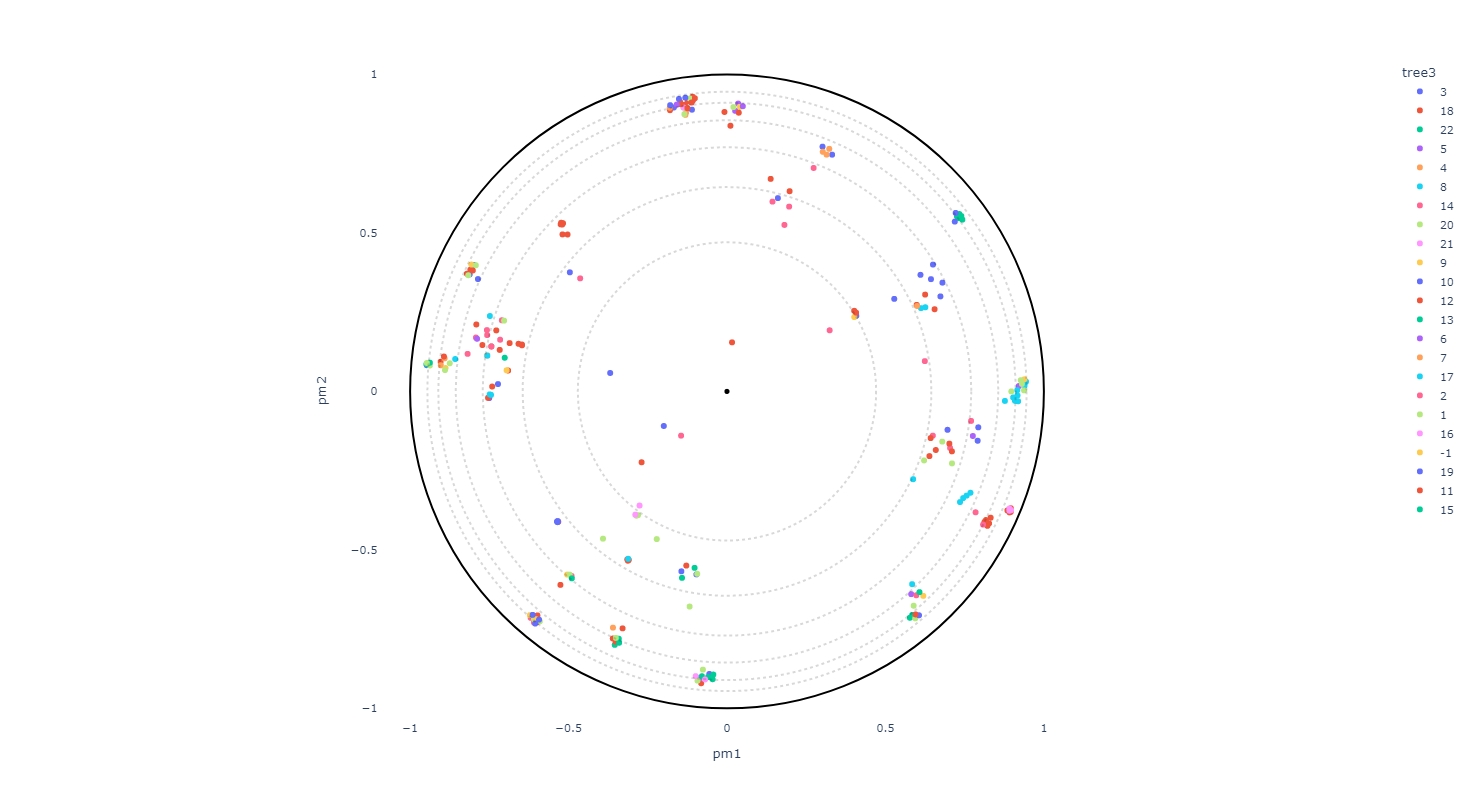

In [54]:
# OPTIONS =================================================
title = ""
#----------------------------------------------------------
# Select the coloring from annotation .csv file:
labels_name = "tree3"
# Select classes to label among the "labels_name" or "second_labels_name" column (list of labels):
second_labels_name = ""
labels_text = []
show_text = True
#----------------------------------------------------------
# Use a custom color palette:
color_palette = None #Default: None
use_custom_palette = False
#==========================================================


#Check projection visualization parameters
#Labels name
if labels_name == "" and path_annotation == "dummy_annotation.csv":
    labels_name = "default"
elif labels_name == "":
    labels_name = None
elif labels_name not in annotation_names:
    raise NameError(f"labels_name {labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}")
#Second labels name
if second_labels_name == "" and path_annotation == "dummy_annotation.csv":
    second_labels_name = "default"
elif second_labels_name == "":
    second_labels_name = None
elif second_labels_name not in annotation_names:
    raise NameError(f'"second_labels_name" {second_labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}')

if not use_custom_palette:
    color_palette = None

#Plot graph
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = labels_name,
                                 second_labels_name = second_labels_name, 
                                 show_text = show_text,
                                 labels_text = labels_text,
                                 color_palette = color_palette, 
                                 title = title, 
                                 fontsize = 11)
fig.show()

### Save plot to file

In [ ]:
# OPTIONS =================================================
output_name = "fig1_cosine"
output_format = "png" #Format availables: ["png", "html", "pdf", "svg"]
#==========================================================


if output_format != "html":
    fig.write_image(f"{output_name}.{output_format}", engine="kaleido")
else:
    fig.write_html(f"{output_name}.{output_format}")